# Define the system  

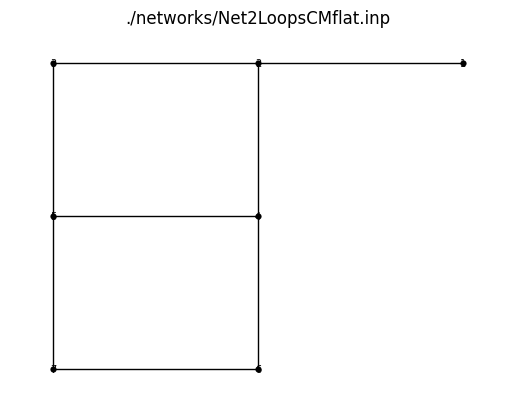

<Axes: title={'center': './networks/Net2LoopsCMflat.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
# inp_file = './networks/Net0.inp'
inp_file = './networks/Net2LoopsDWflat.inp'
inp_file = './networks/Net2LoopsCMflat.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

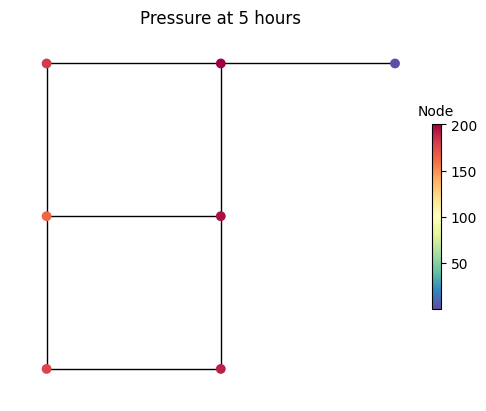

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
ref_pressure = results.node['pressure'].values[0]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 3.111e-01,  5.111e-02,  2.322e-01,  3.108e-02,  1.678e-01,  7.613e-02,  2.334e-02, -2.058e-02,  2.007e+02,  1.817e+02,  1.956e+02,  1.638e+02,  1.905e+02,  1.778e+02,  4.395e-07], dtype=float32)

## Run with the QUBO Polynomial Solver

In [4]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [5]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 7
step = (15/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

nqbit = 7
step = (500/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+500.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 500.000000 => 1000.000000 (res: 3.937008)
Flow Encoding : -15.000000 => -0.000000 | 0.000000 => 15.000000 (res: 0.118110)


Solve the system classically

In [6]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, bin_rep_sol, cvgd = net.classical_solutions()
ref_sol / ref_values[:-1]

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.999, 1.   , 1.001, 1.   , 1.001, 1.   , 1.001])

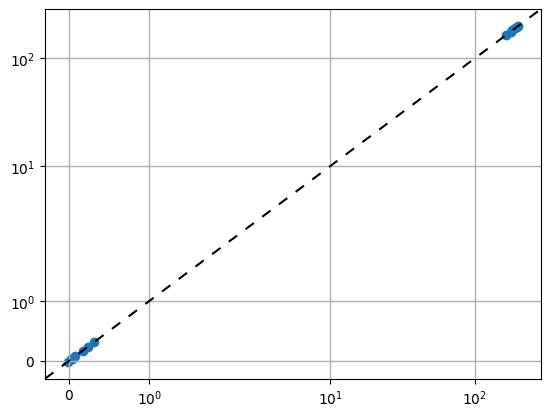

In [7]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol)
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

In [8]:
# from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
# from dwave.samplers import SimulatedAnnealingSampler, TabuSampler, SteepestDescentSampler, RandomSampler

# sampler = SimulatedAnnealingSampler()
# # sampler = TabuSampler()
# # sampler = SteepestDescentSampler()
# # sampler = RandomSampler()
# model, model_updater = create_hydraulic_model_for_qubo(wn)
# net.solve(model, strength=1E7, sampler=sampler, num_sweeps=int(1E1), num_reads=10)
# # sol = net.extract_data_from_model(model)

In [9]:
# solutions,energies,statuses = net.analyze_sampleset()
# for e,s in zip(energies,statuses):
#     print(e,s)


In [10]:
# import matplotlib.pyplot as plt 
# plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')
# for s in solutions[2:4]:
#     plt.scatter(ref_values[:-1], s, s=50, lw=1, edgecolors='w', label='Sampled solution')
# plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
# plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
# plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
# plt.grid(which="major", lw=1)
# plt.grid(which="minor", lw=0.1)
# plt.xlabel('Reference Solution')
# plt.ylabel('QUBO Solution')
# # plt.legend()
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])
# # plt.loglog()

## Own sampler

In [11]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo

model, model_updater = create_hydraulic_model_for_qubo(wn)
net.matrices = net.initialize_matrices(model)

In [12]:
from wntr_quantum.sampler.simulated_annealing import SimulatedAnnealing
sampler = SimulatedAnnealing()

In [13]:
from qubops.qubops_mixed_vars import QUBOPS_MIXED
import sparse
net.qubo = QUBOPS_MIXED(net.mixed_solution_vector, {"sampler": sampler})
matrices = tuple(sparse.COO(m) for m in net.matrices)
net.qubo.qubo_dict = net.qubo.create_bqm(matrices, strength=1E7)

In [14]:
from wntr_quantum.sampler.step.full_random import RandomStep
var_names = sorted(net.qubo.qubo_dict.variables)
net.qubo.create_variables_mapping()
mystep = RandomStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables)

In [15]:
from wntr_quantum.sampler.simulated_annealing import generate_random_valid_sample
x = generate_random_valid_sample(net.qubo)
x0 = list(x.values())

In [16]:
def flatten_list(lst):
    out = []
    for elmt in lst:
        if not isinstance(elmt, list):
            out += [elmt]
        else:
            out += elmt
    return out

from copy import deepcopy
mod_bin_rep_sol = deepcopy(bin_rep_sol)

for i in range(16,22):
    mod_bin_rep_sol[i] = list(np.random.randint(2, size=7))
x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
x0 = list(x.values())


In [19]:
mod_bin_rep_sol

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 [1, 0, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 1],
 [1, 0, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 1, 1, 0],
 [1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 1, 0, 1, 1],
 [1, 1, 0, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 1],
 [1, 1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 1]]

In [20]:
num_sweeps = 9000
Tinit = 1E5
Tfinal = 1E0
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))

In [21]:
res = sampler.sample(net.qubo.qubo_dict, x0=x0, Tschedule=Tschedule, take_step=mystep)

100%|██████████| 10000/10000 [00:33<00:00, 301.79it/s]


In [22]:
bin_rep_sol

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 [1, 0, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 1],
 [1, 0, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 1, 1, 0],
 [1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 1, 0],
 [1, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 0],
 [0, 1, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 0]]

In [23]:
np.array(res.res)[net.qubo.index_variables]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0])

In [24]:
mystep.verify_quadratic_constraints(res.res)

In [25]:
eref = net.qubo.energy_binary_rep(bin_rep_sol)

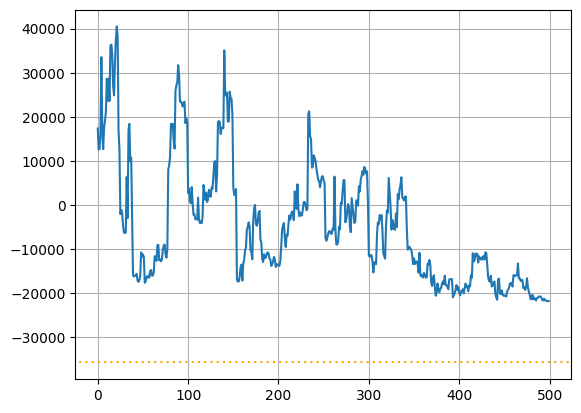

In [36]:
import matplotlib.pyplot as plt
eplt = res.energies[-500:]
plt.plot(eplt)
plt.axline((0, eref[0]), slope=0, color="orange", linestyle=(1, (1, 2)))
plt.grid()
# plt.yscale('symlog')

In [27]:
sol = net.qubo.decode_solution(np.array(res.res))
sol = net.combine_flow_values(sol)
sol = net.convert_solution_to_si(sol)

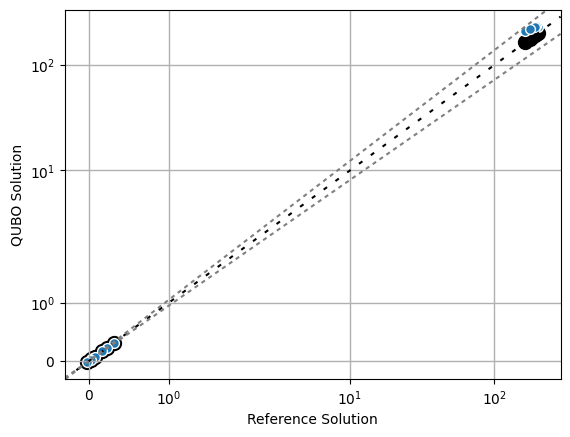

In [30]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')
plt.scatter(ref_values[:-1], sol, s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
# plt.legend()
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

In [39]:
net.verify_solution(net.convert_solution_from_si(ref_values[:-1]))

array([-3.893e-08, -3.893e-08,  2.448e-07, -1.577e-07, -3.686e-07, -8.872e-08,  8.902e-02,  3.336e-01,  4.967e-02,  6.449e-01,  5.442e-02,  1.960e-01,  3.639e-01, -2.829e-01])

In [40]:
net.verify_solution(net.convert_solution_from_si(sol))

array([ 1.295e-02,  1.295e-02, -2.746e-01, -2.546e-01,  3.341e-01,  2.625e-02,  4.496e+01,  5.775e+01, -4.929e+01,  4.860e+01,  1.639e+01, -1.631e+01, -1.127e+02,  1.592e+01])

## Own Sampler Manual

In [13]:
def generate_random_valid_sample(qubo):
    """check if quadratic constraints are respected or not

    Args:
        sampleset (_type_): _description_
    """
    sample = {}
    for iv, v in enumerate(sorted(net.qubo.qubo_dict.variables)):
            sample[v] = 1 # np.random.randint(2)

    for v in qubo.mapped_variables[:7]:
        sample[v] = 1
    sample[qubo.mapped_variables[7]] = 0

    for v, _ in sample.items():
        if v not in qubo.mapped_variables:
            var_tmp = v.split("*")
            itmp = 0
            for vtmp in var_tmp:
                if itmp == 0:
                    new_val = sample[vtmp]
                    itmp = 1
                else:
                    new_val *= sample[vtmp]
            
            sample[v] = new_val
    return sample 

In [14]:

sample = generate_random_valid_sample(net.qubo)


In [15]:
from copy import deepcopy
class OptStep:
    def __init__(self,var_names, single_var_names, single_var_index):
        self.var_names = var_names
        self.single_var_names = single_var_names
        self.single_var_index = single_var_index
        self.num_single_var = len(self.single_var_names)
        self.high_order_terms_mapping = self.define_mapping()

    def define_mapping(self):
        high_order_terms_mapping = []

        # loop over all the variables
        for iv, v in enumerate(self.var_names):
            
            # if we have a cmomposite variables e.g. x_001 * x_002 we ignore it
            if v not in self.single_var_names:
                high_order_terms_mapping.append(None)
            
            # if the variables is a unique one e.g. x_011
            else:
                high_order_terms_mapping.append({})
                # we loop over all the variables
                for iiv, vv in enumerate(self.var_names):
                    if v != vv:
                        if v in vv:
        
                            var_tmp = vv.split("*")
                            idx_terms = []
                            for vtmp in var_tmp:
                                idx = self.single_var_index[self.single_var_names.index(vtmp)]
                                idx_terms.append(idx)
                            high_order_terms_mapping[-1][iiv] = idx_terms

        return high_order_terms_mapping

    def fix_constraint(self, x, idx):
        fix_var = self.high_order_terms_mapping[idx]
        for idx_fix, idx_prods in fix_var.items():
            x[idx_fix] = np.array([x[i] for i in  idx_prods]).prod()
        return x 

    def __call__(self, x):
        vidx = np.random.choice(self.single_var_index)
        if vidx not in self.single_var_index[:8]:
            x[vidx] = int(not(x[vidx]))
            self.fix_constraint(x, vidx)
        return x      

var_names = sorted(net.qubo.qubo_dict.variables)
mytakestep = OptStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables)
mytakestep.high_order_terms_mapping[0]
x0 = list(sample.values())
x0_cpy = deepcopy(list(sample.values()))
x = mytakestep(x0)

In [16]:
sorted(net.qubo.qubo_dict.variables)

['x_001_001',
 'x_001_001*x_009_001',
 'x_001_001*x_009_001*x_009_006',
 'x_001_001*x_009_001*x_009_007',
 'x_001_001*x_009_001*x_009_008',
 'x_001_001*x_009_002',
 'x_001_001*x_009_002*x_009_007',
 'x_001_001*x_009_003',
 'x_001_001*x_009_003*x_009_006',
 'x_001_001*x_009_003*x_009_007',
 'x_001_001*x_009_003*x_009_008',
 'x_001_001*x_009_004',
 'x_001_001*x_009_004*x_009_001',
 'x_001_001*x_009_004*x_009_002',
 'x_001_001*x_009_004*x_009_006',
 'x_001_001*x_009_004*x_009_007',
 'x_001_001*x_009_004*x_009_008',
 'x_001_001*x_009_004*x_009_009',
 'x_001_001*x_009_005',
 'x_001_001*x_009_005*x_009_001',
 'x_001_001*x_009_005*x_009_002',
 'x_001_001*x_009_005*x_009_003',
 'x_001_001*x_009_005*x_009_004',
 'x_001_001*x_009_005*x_009_006',
 'x_001_001*x_009_005*x_009_007',
 'x_001_001*x_009_005*x_009_008',
 'x_001_001*x_009_005*x_009_009',
 'x_001_001*x_009_006',
 'x_001_001*x_009_006*x_009_007',
 'x_001_001*x_009_007',
 'x_001_001*x_009_008',
 'x_001_001*x_009_008*x_009_006',
 'x_001_001*

In [17]:
from dimod import as_samples 
def bqm_energy(x):
    return net.qubo.qubo_dict.energies(as_samples((x, var_names)))
bqm_energy(x)

array([1.141e+09])

In [18]:
from tqdm import tqdm
num_sweeps = 9000
Tinit = 1E5
Tfinal = 1E-1
sample = generate_random_valid_sample(net.qubo)
x = list(sample.values())
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))
# Tschedule = np.zeros(10000)
energies = []
energies.append(bqm_energy(x))
for T in tqdm(Tschedule):

    x_ori = deepcopy(x)
    e_ori = bqm_energy(x)
    x_new = mytakestep(x) 
    e_new = bqm_energy(x)

    if e_new < e_ori:
        x = x_new
        energies.append(bqm_energy(x))
    elif T != 0.0:
        p = np.exp( -(e_new - e_ori) / T )
        if np.random.rand() < p:
            x = x_new
            energies.append(bqm_energy(x))
        else:
            x = x_ori    
    else:
        x = x_ori
# mytakestep.verify_quadratic_constraints(x)

100%|██████████| 10000/10000 [01:06<00:00, 150.15it/s]


AttributeError: 'OptStep' object has no attribute 'verify_quadratic_constraints'

In [19]:
def flatten_list(lst):
    out = []
    for l in lst:
        if not isinstance(l, list):
            out += [l]
        else:
            out += l
    return out
bin_rep_sol_flat = flatten_list(bin_rep_sol)

In [20]:
eref = bqm_energy(net.qubo.extend_binary_representation(bin_rep_sol_flat))

/tmp/ipykernel_7683/121086906.py:3: DeprecationWarning: support for (dict, labels) as a samples-like is deprecated since dimod 0.10.13 and will be removed in 0.12.0
  return net.qubo.qubo_dict.energies(as_samples((x, var_names)))


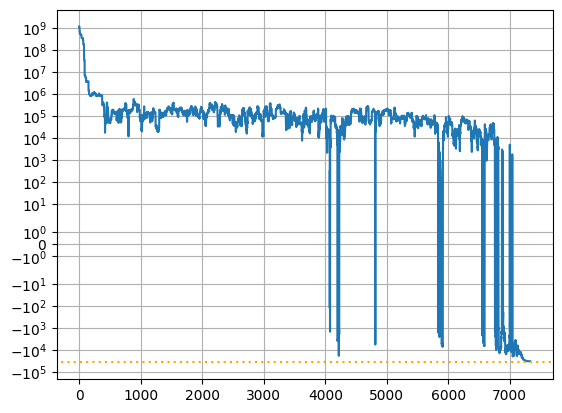

In [21]:
import matplotlib.pyplot as plt
eplt = energies #[-200:]
plt.plot(eplt)
plt.axline((0, eref[0]), slope=0, color="orange", linestyle=(1, (1, 2)))
plt.grid()
plt.yscale('symlog')

In [22]:
sol = net.qubo.decode_solution(np.array(x))
sol = net.combine_flow_values(sol)
sol = net.convert_solution_to_si(sol)

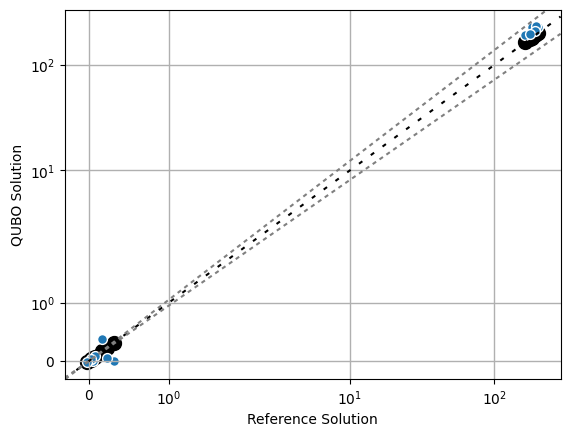

In [23]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')
plt.scatter(ref_values[:-1], sol, s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
# plt.legend()
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

In [24]:
bin_rep_sol

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 [0, 1, 1, 0, 1, 1, 1, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 1],
 [1, 0, 1, 0, 0, 1, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 1, 1, 0],
 [0, 0, 1, 1, 1, 0, 1, 0, 0],
 [0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 1, 0, 0, 1, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0]]

In [25]:
encoded_ref_sol

array([ 3.109e-01,  5.070e-02,  2.319e-01,  3.076e-02,  1.679e-01,  7.647e-02,  2.327e-02, -2.078e-02,  2.007e+02,  1.819e+02,  1.956e+02,  1.640e+02,  1.906e+02,  1.778e+02])

In [26]:
def create_variables_mapping(qubo):
    """generates the index of variables in the solution vector

    Args:
        sol (dimod.Sampleset): sampleset from the sampler
    """

    # get all the possible variable prefixes
    prefixes = list(
        set(
            [
                sv.base_name + "_"
                for sv in qubo.mixed_solution_vectors.solution_vectors
            ]
        )
    )

    # extract the data of the original variables
    index_variables, mapped_variables = [], []
    for ix, s in enumerate(sorted(qubo.qubo_dict.variables)):
        if s in qubo.all_vars and np.any([s.startswith(pf) for pf in prefixes]):
            index_variables.append(ix)
            mapped_variables.append(s)
    return index_variables, mapped_variables 

create_variables_mapping(net.qubo)

([0,
  34,
  37,
  38,
  63,
  74,
  98,
  111,
  150,
  157,
  171,
  175,
  184,
  191,
  193,
  196,
  200,
  207,
  222,
  231,
  243,
  244,
  259,
  272,
  283,
  290,
  295,
  305,
  317,
  325,
  342,
  352,
  358,
  372,
  376,
  385,
  389,
  396,
  398,
  406,
  423,
  440,
  446,
  450,
  451,
  461,
  477,
  483,
  498,
  509,
  515,
  518,
  520,
  531,
  535,
  546,
  553,
  570,
  571,
  574,
  576,
  593,
  598,
  609,
  614,
  618,
  623,
  640,
  641,
  651,
  667,
  676,
  680,
  689,
  697,
  698,
  700,
  703,
  708,
  717,
  728,
  729,
  730,
  731,
  732,
  733,
  734,
  735,
  736,
  737,
  738,
  739,
  740,
  741,
  742,
  743,
  744,
  745,
  746,
  747,
  748,
  749,
  750,
  751,
  752,
  753,
  754,
  755,
  756,
  757,
  758,
  759,
  760,
  761,
  762,
  763,
  764,
  765,
  766,
  767,
  768,
  769,
  770,
  771,
  772,
  773,
  774,
  775,
  776,
  777,
  778,
  779,
  780,
  781],
 ['x_001_001',
  'x_002_001',
  'x_003_001',
  'x_004_001',
  'x_005_

In [27]:
from wntr_quantum.sampler.simulated_annealing import generate_random_valid_sample, ProposalStep, SimulatedAnnealing

In [28]:
mystep = ProposalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables)

In [29]:
x = generate_random_valid_sample(net.qubo)
sampler = SimulatedAnnealing()

In [30]:
sampler.sample(net.qubo.qubo_dict, x0=x, take_step=mystep)

AttributeError: 'SimulatedAnnealing' object has no attribute 'variables'

In [156]:
callable(mystep)

True